# ConvAutoencoder MNISTdataset

Let's now build a Conv Autoencoder on the MNIST dataset.

In [9]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose

from tensorflow.keras.models import Model  

from tensorflow.keras.datasets import mnist  # MNIST dataset

import numpy as np

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('There are {} samples in the training set'.format(x_train.shape[0]))
print('There are {} samples in the test set'.format(x_test.shape[0]))

There are 60000 samples in the training set
There are 10000 samples in the test set


Normalization

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Adding the channels dimension.

In [6]:
(n_train, w, h) = x_train.shape
# Reshaping `x_train`, adding the channels dimension (equal to 1)
x_train = x_train.reshape(n_train, w, h, 1)

(n_test, w, h) = x_test.shape
# Reshaping `n_test`, adding the channels dimension (equal to 1)
x_test = x_test.reshape(n_test, w, h, 1)

### Autoencoder

Let's define a very simple Conv Autoencoder. 
1. The encoder part consists of two Conv layers, which produce the latent encoding $z$.
2. The decoder part consists of two Dense layers, which reconstruct back the input $x$.

Let's see that more in depth.

**Input**

The input $x_{in}$ is an image with dimensions $28x28x1$. Each value is between $0$ and $1$.

**Encoder**

The encoder consists in two Conv layers. The first has output of dimensions $14x14x16$. The second has output of dimensions $7x7x32$.

We are decreasing the spatial dimensions and increasing tha channels dimension.

The output of this encoder part is our latent encoding $z$. It has dimensions $7x7x32$.

**Decoder**

It is completely simmetric to the encoder. We increase the spatial dimensions, we decrease the channels dimension.

For increasing the spatial dimensions, we use the **transposed convolution**.

Two Transposed Conv layers. The first has output of dimensions $14x14x16$. The first has output of dimensions $28x28x1$.

The output of this decoder part is the reconstructed image $x_{out}$.

We want that each value is between $0$ and $1$, therefore we use the **sigmoid** activation function for the last dense layer. (Instead, all the other conv layers have the no activation function).

**Important remark: no compression**

It is important to notice in this case out latent encoding $z$ has no smaller dimensions than the input $x_{in}$. The input has $28*28*1=784$ values. The latent encoding has $7*7*31=784$ values. No compression. We have simplied decreased the spatial dimensions and, at the same time, increased the number of channels.

In [37]:
### INPUT
xin = Input(shape=(28,28,1))

### ENCODER
x = Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='same')(xin)
z = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same')(x)  # Latent encoding z

### DECODER
x = Conv2DTranspose(filters=16, kernel_size=(3,3), strides=(2,2), padding='same')(z)
xout = Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(2,2), padding='same', 
                       activation='sigmoid')(x) # Reconstructed image

### MODEL
autoencoder = Model(inputs=xin, outputs=xout)

In [38]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 14, 14, 16)       4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 28, 28, 1)        145       
 Transpose)                                                      
                                                                 
Total params: 9,569
Trainable params: 9,569
Non-trainable p

### Compiling

We define ADAM as optimizer.

As loss function, we can use the MSE, or the binary cross-entropy (since we are using the sigmoid function).

The idea of the loss function is the following. We have two images $x_{in}$, which is the ground truth, and $x_{out}$, which is the reconstruction. Both of them are tensors with dimensions $28x28x1$. We measure the distance (e.g. MSE or binary crossentropy) between each pair of corresponding pixel in the two tensors: we get a tensor of $28x28x1$ error values. Then, we aggregate these $28x28x1$ errors into a single error: this is our final loss value (we compute the mean).

In [39]:
from tensorflow.keras.optimizers import Adam  # We import the optimizer
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

### Training

We try the autoencoder. It is important to notice that the we are giving as labels the data iteslf. We are giving `<x_train,x_train>` to the `fit` method.

In [29]:
autoencoder.fit(x_train, x_train, epochs=5, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/5
235/235 [==============================] - 8s 32ms/step - loss: 0.0139 - val_loss: 0.0027
Epoch 2/5
235/235 [==============================] - 7s 31ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 3/5
235/235 [==============================] - 7s 29ms/step - loss: 7.4148e-04 - val_loss: 5.3467e-04
Epoch 4/5
235/235 [==============================] - 7s 29ms/step - loss: 3.9519e-04 - val_loss: 2.7586e-04
Epoch 5/5
235/235 [==============================] - 7s 29ms/step - loss: 1.8461e-04 - val_loss: 1.0875e-04


*Much better scores than the ones obtained by the Dense autoencoder!!! And with less epochs!!!*

### Inspect the results

Let's inspect the quality of the results.

First of all, we apply the autoencoder to the test data $x_{test}$: we get back the reconstruction $\hat{x}_{test}$ of the test data.

In [30]:
x_test_hat = autoencoder.predict(x_test)

Now we can plot the result. We pick ten random test images, and for each of them we show the original and the reconstruction obtained from the autoencoder.

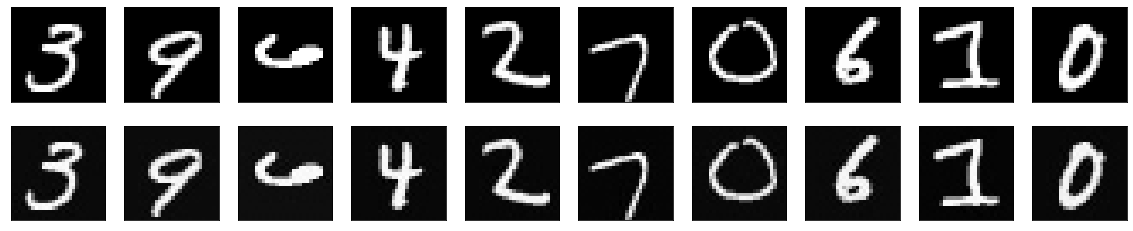

In [31]:
import matplotlib.pyplot as plt

n = 10 #number of images to plot
images_indeces = np.random.randint(low=0,high=10000,size=n)

plt.figure(figsize=(20, 4))

for (i,idx) in enumerate(images_indeces):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_hat[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Quite good results!